# ProxyStore with FaaS for RDMA Stores

In this experiment, we use the distributed in-memory connectors to measure intra-site communication via advanced networking technologies (i.e., RDMA).
This experiment is a modification of `0-proxystore-with-faas`.

## Instructions

**Warning:** In the original CSV files used to generate the plots in the paper, the ProxyStore implementations were called "XStore" (e.g., "RedisStore"), but now the benchmark scripts will use "XConnector" in the CSV file. If you run into compatibility issues with this notebook, find and replace "Connector" -> "Store" in your input CSV files.

### Setup

Setup needs to be performed on all sites that will be used.

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```

2. Configure a FuncX endpoint. Note that the endpoint configuration will need to be changed customized for the system, allocations, etc.
   ```bash
   $ globus-compute-endpoint configure psbench
   $ globus-compute-endpoint start psbench
   ```
   Endpoint config reference: https://globus-compute.readthedocs.io/en/latest/executor.html

3. Configure a ProxyStore endpoint
   ```bash
   $ proxystore-endpoint configure psbench --relay-server {SIGNALING SERVER}
   $ proxystore-endpoint start psbench
   ```
   Note: endpoint logs will still be written to `~/.local/share/proxystore/psbench`, and the endpoint should be stopped after testing.

### Run

**Note:** this benchmark used to be in `psbench.benchmarks.funcx_tasks`.

```bash
$ python -m psbench.benchmarks.globus_compute_tasks \
    --gc-endpoint {UUID} \  # UUID returned by globus-compute-endpoint start
    --task-repeat 5 \
    --task-sleep 0.0 \
    --input-sizes 100 1000 10000 \
    --output-sizes 0 \
    --ps-backend ENDPOINT --ps-endpoints {UUID} {UUID} \ # UUIDs for all ProxyStore endpoints
    --csv-file {OUTPUT-CSV-FILE}
```

### Notes

- All experiments done with Python 3.10.8
- proxystore-benchmark commit hash used: `bf643cd2dee85e243f92c824cd701ee02ac8ace5`
- When a job is needed for a worker, its best to run a small benchmark to allocate nodes then run the benchmark for real.
- ZMQStore used a 1GB chunk size.

In [2]:
%matplotlib inline

import math

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy
import warnings

In [3]:
BACKEND_COLUMN = 'proxystore_backend'
INPUT_SIZE_COLUMN = 'input_size_bytes'
TOTAL_TIME_COLUMN = 'total_time_ms'
SLEEP_COLUMN = 'task_sleep_seconds'

def load(filepath: str) -> pandas.DataFrame:
    df = pandas.read_csv(filepath)
    df[BACKEND_COLUMN] = df[BACKEND_COLUMN].fillna('Globus Compute')
    return df

In [4]:
def get_backends(data: pandas.DataFrame):
    return data[BACKEND_COLUMN].unique()

def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def get_input_sizes(data: pandas.DataFrame):
    return list(data[INPUT_SIZE_COLUMN].unique())

def get_avg_total_time(data: pandas.DataFrame) -> float:
    """Drops min/max and takes average of remaining times."""
    times = list(data[TOTAL_TIME_COLUMN])
    if len(times) < 3:
        raise ValueError('Cannot drop min/max value when row count < 3')
    times.remove(min(times))
    times.remove(max(times))
    if len(times) > 3:
        times.remove(min(times))
        times.remove(max(times))
    return sum(times) / len(times)

def extract_avg_times(data: pandas.DataFrame):
    # Input dataframe should just contain one backend type
    assert len(get_backends(data)) == 1
    input_sizes = get_input_sizes(data)
    input_sizes
    avg_times = [
        get_avg_total_time(rows_matching_column_value(data, INPUT_SIZE_COLUMN, input_size)) for input_size in input_sizes
    ]
    # Convert to seconds
    avg_times = [x / 1000 for x in avg_times]
    return {'sizes': input_sizes, 'times': avg_times}

def extract(data: pandas.DataFrame):
    result = {}
    for backend in get_backends(data):
        subset = rows_matching_column_value(data, BACKEND_COLUMN, backend)
        result[backend] = extract_avg_times(subset)
        result[backend]['yerr'] = get_stdev(subset)
    return result

def get_stdev(data: pandas.DataFrame):
    # Get Data for a particular backend
    backend_data = data[[INPUT_SIZE_COLUMN, TOTAL_TIME_COLUMN]].copy()
    
    TOTAL_TIME_S = 'total_time_s'
    # Convert total time of backend to seconds
    backend_data[TOTAL_TIME_S] = backend_data[TOTAL_TIME_COLUMN].div(1000)
    
    # drop min and max values for each input size
    backend_data = backend_data.drop(backend_data.groupby(INPUT_SIZE_COLUMN)[TOTAL_TIME_S].idxmin())
    backend_data = backend_data.drop(backend_data.groupby(INPUT_SIZE_COLUMN)[TOTAL_TIME_S].idxmax())

    backend_seconds = backend_data.groupby(INPUT_SIZE_COLUMN)
    
    # Return std as list
    return backend_seconds.std()[TOTAL_TIME_S].to_list()

# Intrasite experiments

Notes:
- Compared IntrasiteStore websockets, mochi, and ucx implementations with FileStore and Redis
- All experiments used 3.9.12 with the exception of UCX-py which required Python 3.7 (installed as per Read-the-docs instructions)

In [5]:
pandas.set_option('display.max_rows', 500)
polaris_noop_data = load('data/1-proxystore-with-faas-rdma/polaris-noop.csv')
chameleon_noop_data = load('data/1-proxystore-with-faas-rdma/chameleon-noop.csv')
extracted_polaris = extract(polaris_noop_data)
extracted_chameleon = extract(chameleon_noop_data)

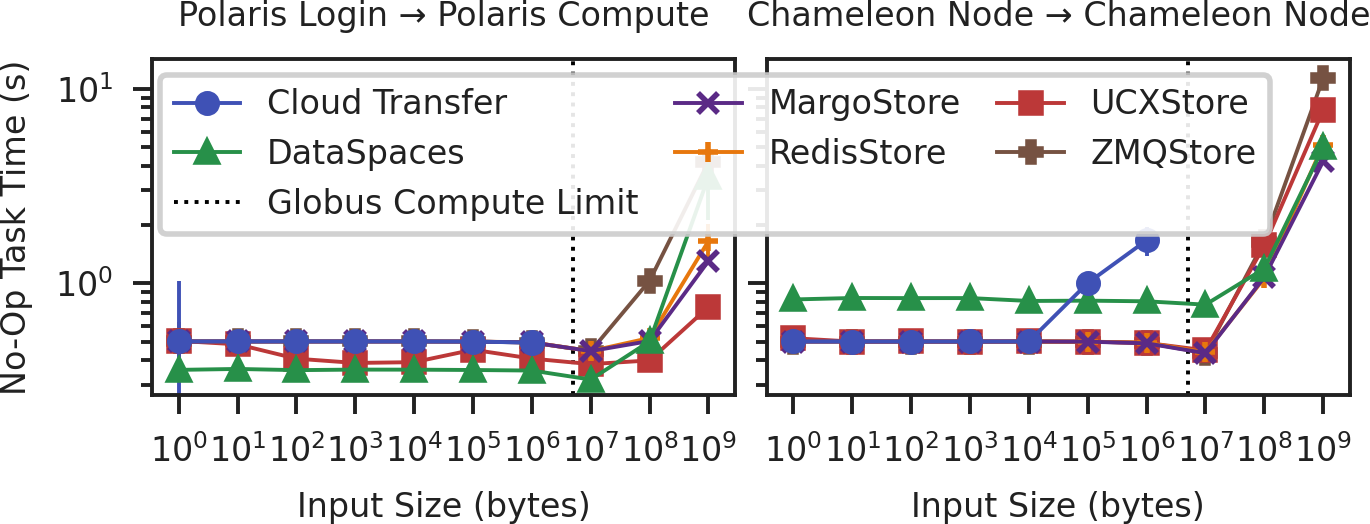

In [20]:
i_backends = ['Globus Compute', 'DataSpaces', 'MargoStore', 'RedisStore', 'UCXStore', 'ZeroMQStore']

fig, axs = plt.subplots(1, 2, sharey=True)

colors = plt.rcParams['axes.prop_cycle'] + cycler(marker=['o', '^', 'x', '+', 's', 'P'])
cycles = {b: c for b, c in zip(i_backends, colors)}
legend_handles = {}  # backend (str): axs handle

for data, ax in zip((extracted_polaris, extracted_chameleon), axs):
    ax.set_xscale('log')
    ax.set_xticks([10 ** x for x in range(0, 10)])

    ax.axvline(5e6, color='black', linestyle=':', label='Globus Compute Limit')
    
    for backend in reversed(i_backends):
        if backend in data:
            xyz = [(x, y, z) for x, y, z in zip(data[backend]['sizes'], data[backend]['times'], data[backend]['yerr']) if 0 < x < 1e10]
            x, y, z  = zip(*xyz)
            ax.errorbar(x, y, yerr=z, label=backend, **cycles[backend])

    handles, labels = ax.get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label == 'ucx':
            label = 'UCXStore'
        elif label == 'margo':
            label = 'MargoStore'
        elif label == 'ZeroMQStore':
            label = 'ZMQStore'
        elif label == 'Globus Compute':
            label = 'Cloud Transfer'
        if label not in legend_handles:
            legend_handles[label] = handle

axs[0].set_xlabel('Input Size (bytes)')
axs[1].set_xlabel('Input Size (bytes)')
axs[0].set_ylabel('No-Op Task Time (s)')
axs[0].set_title('Polaris Login → Polaris Compute')
axs[1].set_title('Chameleon Node → Chameleon Node')

# Reorder legend
backends = ['Cloud Transfer', 'DataSpaces', 'Globus Compute Limit', 'MargoStore', 'RedisStore', 'UCXStore', 'ZMQStore']
handles = [None for _ in range(len(backends))]
labels = [None for _ in range(len(backends))]
for label, handle in legend_handles.items():
    index = backends.index(label)
    if label != 'Globus Compute Limit':
        handle = handle[0]
    handles[index] = handle
    labels[index] = label

fig.legend(
    handles,
    labels,
    bbox_to_anchor=[0.503, 0.94],
    ncol=3,
    loc='upper center',
    columnspacing=1.1,
    fancybox=True,
    framealpha=0.9,
)

axs[0].set_yscale('log')

# Restrict y axis range
# axs[0].set_ylim([0, 12])

# Restrict y labels to integers
# axs[0].get_yaxis().set_major_locator(mticker.MaxNLocator(integer=True))

fig.tight_layout(h_pad=0.5, w_pad=0.75)

fig.set_size_inches(3.35, 1.0)
plt.savefig('figures/globus-compute-roundtrip-task-times-intrasite.pdf', pad_inches=0.05)